In [1]:
from experiment.Experiment import Experiment
from experiment.ExperimentSet import ExperimentSet
from utils.read import read_UCR_dataset_name

from sktime.classification.kernel_based import RocketClassifier

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [49]:
from sktime.datasets import load_UCR_UEA_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from utils.mlflow_saving import mlflow_save_result
from utils.read import reshape_new_to_old_format, reshape_old_to_new_format


# TODO: Verbose
# TODO: Feature unit-test:
# TODO: Describe Function: Get Experiment class information
class Experiment:
    def __init__(
        self,
        clasifier=None,
        dataset=None,
        augment={"name": str(None), "params": str(None)},
        verbose=0,
    ):
        self.clasifier = clasifier
        self.dataset = dataset
        self.augment = augment
        self.y_pred = None
        self.evaluation_metric = {}
        self.verbose = verbose

    def load_UCR_dataset(self, dataset: str = None):
        dataset_name = self.dataset if self.dataset else dataset
        x_train, y_train = load_UCR_UEA_dataset(
            dataset_name, split="train", return_X_y=True, return_type="numpy2D"
        )
        x_test, y_test = load_UCR_UEA_dataset(
            dataset_name, split="test", return_X_y=True, return_type="numpy2D"
        )
        # TODO: Data Inconsistency with interface
        self.dataset = {
            "name": dataset_name,
            "x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test,
        }

    def augmentation(self):
        if self.augment["name"] == "None":
            return
        x_train = reshape_new_to_old_format(self.dataset["x_train"])
        x_test = reshape_new_to_old_format(self.dataset["x_test"])

        if self.augment['enter_label']:
            x_train_aug = self.augment["function"](x_train, self.dataset["y_train"], **self.augment["params"])
            x_test_aug = self.augment["function"](x_test, self.dataset["y_test"], **self.augment["params"])

        else:
            x_train_aug = self.augment["function"](x_train, **self.augment["params"])
            x_test_aug = self.augment["function"](x_test, **self.augment["params"])

        self.dataset["x_train_aug"] = reshape_old_to_new_format(x_train_aug)
        self.dataset["x_test"] = reshape_old_to_new_format(x_test_aug)

    def train_classier(self):
        self.clasifier["function"].fit(self.dataset["x_train"], self.dataset["y_train"])

    def predict(self):
        self.y_pred = self.clasifier["function"].predict(self.dataset["x_test"])

    def evaluate(self):
        self.evaluation_metric["accuracy"] = accuracy_score(
            self.dataset["y_test"], self.y_pred
        )
        (
            self.evaluation_metric["precision"],
            self.evaluation_metric["recall"],
            self.evaluation_metric["fbeta"],
            self.evaluation_metric["support"],
        ) = precision_recall_fscore_support(self.dataset["y_test"], self.y_pred)

    def save_result(self):
        mlflow_save_result(
            {"accuracy": self.evaluation_metric["accuracy"]},
            {"model": self.clasifier["name"]},
            {
                "dataset": self.dataset["name"],
                "datapoint_shape": str(self.dataset["x_train"].shape)
                + "x"
                + str(self.dataset["x_test"].shape),
                "number_of_class": len(set(list(self.dataset["y_test"]))),
            },
            {
                "augmentation": {
                    "name": self.augment["name"],
                    "params": self.augment["params"],
                },
            },
            # [{"data": self.augment["params"], "file_name": "dict/augmentation.json"}],
        )
        print(f'{self.clasifier["name"]}, {self.dataset["name"]}, ({self.augment["name"]}, {self.augment["params"]}) DONE')

    def run_all(self):
        self.load_UCR_dataset()
        self.augmentation()
        self.train_classier()
        self.predict()
        self.evaluate()
        # self.save_result()

#### Window Slice

In [70]:
from time_series_augmentation.utils.pun_augmentation import window_slice

# AUGMENTED
variation = 'minirocket'
classifer = {'name':variation, 'function': RocketClassifier(rocket_transform=variation)}
dataset = 'ECG5000'
augment = {'name':window_slice.__name__, 'function': window_slice, 'params': {'reduce_ratio': 0.5}, 'enter_label': False}

In [71]:
training = Experiment(classifer, dataset, augment)
training.load_UCR_dataset()
training.augmentation()

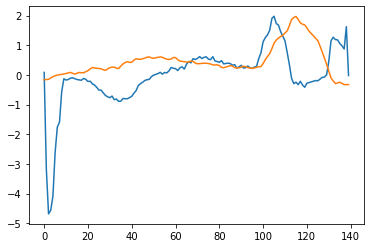

In [72]:
import matplotlib.pyplot as plt
plt.plot(training.dataset["x_train"][10])
plt.plot(training.dataset["x_train_aug"][10][0])

#### Window Warp

In [92]:
from time_series_augmentation.utils.pun_augmentation import window_warp

# AUGMENTED
variation = 'minirocket'
classifer = {'name':variation, 'function': RocketClassifier(rocket_transform=variation)}
dataset = 'ECG5000'
augment = {'name':window_warp.__name__, 'function': window_warp, 'params': {'window_ratio': 0.5}, 'enter_label': False}

In [93]:
training = Experiment(classifer, dataset, augment)
training.load_UCR_dataset()
training.augmentation()

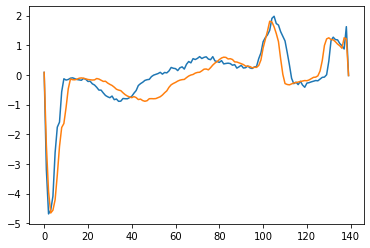

In [94]:
import matplotlib.pyplot as plt
plt.plot(training.dataset["x_train"][10])
plt.plot(training.dataset["x_train_aug"][10][0])